In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
import sklearn.naive_bayes
import sklearn.neural_network
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

import seaborn as sns

## Read Data

In [2]:
def read_csv(filepath):
    '''
    Takes a csv and returns a pandas data frame
    
    Input:
        filepath (directory path): file location
        
    Output:
        pandas data frame
    '''
    
    return pd.read_csv(filepath)

In [3]:
main = read_csv('credit-data.csv')

## Pre-Process Data

In [4]:
def replace_na_with_mean(df, var):
    '''
    Replaces all the NA's in a given column with the mean of that column.
    
    Input:
        df (pandas dataframe): original dataframe
        var (string): column containing NA values
    '''
    
    mean_var = main[var].mean()
    main[var].fillna(mean_var, inplace=True)

In [5]:
def fill_missing_with_mean(df):
    '''
    Takes a dataframe and replaces all NA's in all columns with the mean.
    
    Input:
        df (pandas dataframe): original dataframe
    '''
    na_cols = list(df.loc[:, df.isna().any()].columns)
    for col in na_cols:
        replace_na_with_mean(df, col) 
        
    return df

In [6]:
def na_cols(df):
    '''
    Produces a list of columns in the data frame that have N/A values.
    
    Input:
        df (data frame): data frame of interest
        
    Output:
        list of columns that contain N/A's
    '''
    
    return list(main.loc[:, main.isna().any()].columns)

In [7]:
na_cols(main)

['MonthlyIncome', 'NumberOfDependents']

In [8]:
main['NumberOfDependents'].describe()

count    39979.000000
mean         0.773231
std          1.121269
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         13.000000
Name: NumberOfDependents, dtype: float64

In [9]:
main['MonthlyIncome'].describe()

count    3.304200e+04
mean     6.578996e+03
std      1.344683e+04
min      0.000000e+00
25%      3.333000e+03
50%      5.250000e+03
75%      8.055750e+03
max      1.794060e+06
Name: MonthlyIncome, dtype: float64

In [10]:
main = fill_missing_with_mean(main)

# The columns that contain N/As are NumberOfDependents and MonthlyIncome. These are both demographic factors for which
# economists and sociologists often look at the mean as representative of the sample as a whole. Therefore
# in order to facilitate analysis without removing data points the mean is used in this analysis.

In [11]:
# removes person ID and zip code, values you cannot take statistical measures of 

statistical = main[['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines',
       'age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
       'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans',
       'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines',
       'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']]

In [12]:
# removed ages where there is not continous or sufficient data 

by_age = statistical.groupby('age').mean()
by_age = by_age.drop([103, 109, 96, 97, 98, 99])

## Explore Data

In [13]:
def plot_line_graph(df, var, title, xlabel, ylabel):
    '''
    Plots a line graph based on columns in a pandas data frame
    
    Inputs:
        df (pandas data frame): data frame containing values to be graphed
        var (str): column name of dependent variable
        title (str): title for line graph
        xlabel (str): label for x-axis
        ylabel (str): label for y-axis
    '''

    x = list(df.index.values)
    y = list(df[var].values)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x,y)
    plt.show()

#### Correlation Heatmap

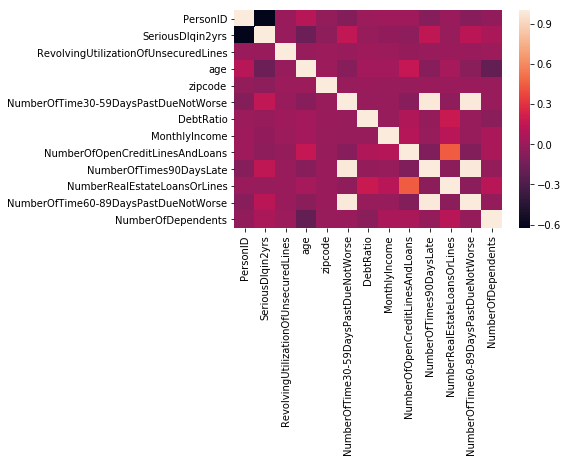

In [14]:
corr = main.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
plt.show()

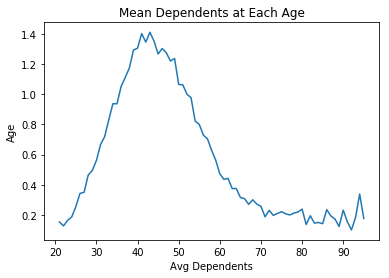

In [15]:
plot_line_graph(by_age, 'NumberOfDependents', 'Mean Dependents at Each Age', 'Avg Dependents', 'Age')

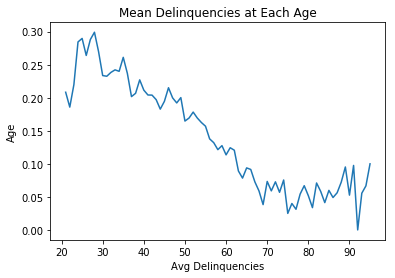

In [16]:
plot_line_graph(by_age, 'SeriousDlqin2yrs', 'Mean Delinquencies at Each Age', 'Avg Delinquencies', 'Age')

## Generate Features/Predictors

In [17]:
def add_dummy_variable(df, var, dummy_var, lambda_eq):
    '''
    Adds a column with a dummy variable based on a column currently in the data frame. 
    
    Inputs:
        df (pandas data frame): the pandas data frame that contains the current data and variable and that the 
        dummy variable will be added to
        var (str): column name of origin variable
        dummy_var (str): column name for dummy variable
        lambda_eq (lambda equation): equation in the form 'lambda x: x < 23550' to turn the 'var' into the 'dummy_var'
    '''
    
    df[dummy_var] = df[var].apply(lambda_eq)

In [18]:
def add_discrete_variable(df, var, discrete_var, num_categories):
    '''
    Adds a column with a discretized variable based on a column currently in the data frame. 
    
    Inputs:
        df (pandas data frame): the pandas data frame that contains the current data and variable and that the 
        dummy variable will be added to
        var (str): column name of origin variable
        discrete_var (str): column name for discretized variable
        num_categories (int): the number of categories to divide the 'var' into. 
    '''
    
    df[discrete_var] = pd.cut(df[var], num_categories)

In [19]:
main_plus = main.copy()

In [20]:
add_dummy_variable(main_plus, 'MonthlyIncome', 'Impoverished', lambda x: x < 23550)

In [21]:
grouped_stats = main_plus.groupby('Impoverished').count().PersonID
not_impoverished, impoverished = grouped_stats[0], grouped_stats[1]
total = main_plus.shape[0]
percent_in_poverty = str(round((impoverished/total)*100))
print(percent_in_poverty + "% of the people in this study have an income below the poverty line for a family of 4.")

99.0% of the people in this study have an income below the poverty line for a family of 4.


In [22]:
add_discrete_variable(main_plus, 'NumberOfTimes90DaysLate', 'Discrete NumberOfTimes90DaysLate', 200)

In [23]:
main_plus.head()

,PersonID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,Impoverished,Discrete NumberOfTimes90DaysLate
0,98976,0,1.000000,55,60601,0,505.000000,0.0,2,0,0,0,0.0,True,"(-0.098, 0.49]"
1,98991,0,0.547745,71,60601,0,0.459565,15666.0,7,0,2,0,0.0,True,"(-0.098, 0.49]"
2,99012,0,0.044280,51,60601,0,0.014520,4200.0,5,0,0,0,0.0,True,"(-0.098, 0.49]"
3,99023,0,0.914249,55,60601,4,0.794875,9052.0,12,0,3,0,0.0,True,"(-0.098, 0.49]"
4,99027,0,0.026599,45,60601,0,0.049966,10406.0,4,0,0,0,2.0,True,"(-0.098, 0.49]"


## Build Classifier

In [24]:
def divide_df(df, var, test_size = 0.3):
    '''
    Divides a data frame into testing and training data frames
    
    Inputs:
        df (pandas data frame): original data frame
        var (string): column name for dependent variable
        test_size (int): weighting for test vs. train division
        
    Outputs:
        x_train, x_test, y_train, y_test = divided data frames to use for classification      
    '''
    
    x = df
    y = df[var]
    test_size = 0.3
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    
    return x_train, x_test, y_train, y_test

In [25]:
x_train, x_test, y_train, y_test = divide_df(main, 'SeriousDlqin2yrs', test_size = 0.3)

#### K Nearest Neighbors

In [28]:
def find_best_n(max_n, max_params, x_train, y_train, x_test, y_test, metric='minkowski'):
    '''
    Finds the optimal number of neighbors and parameters to look at when conducting a 
    K-nearest neighbors classification.
    
    Inputs:
        max_n (int): maximum number of k-neighbors
        max_params (int): maximum number of metric parameters
        metric (str): distance metric
        x_train, y_train, x_test, y_test (pandas data frames): divided data frames to conduct
            training and testing
            
    Output:
        KNeighborsClassifier function with the optimal parameters for the given data. 
    '''
    
    best_score, best_n, best_mp = 0, 0, 0
    for n in range(1, max_n+1):
        for mp in range(1, max_params+1):
            knn = KNeighborsClassifier(n_neighbors=n, metric=metric, metric_params={'p': mp})
            knn.fit(x_train, y_train)
            s = knn.score(x_test, y_test)
            if s > best_score:
                best_n = n
                best_mp = mp
            
    print("The optimal value for k is " + str(best_n) + " with " + str(best_mp) + " metric parameters. ")
    return KNeighborsClassifier(n_neighbors=best_n, metric=metric, metric_params={'p': best_mp})

In [29]:
knn = find_best_n(10, 10, x_train, y_train, x_test, y_test, 'minkowski')
knn.fit(x_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:20: SyntaxWarning: Parameter p is found in metric_params. The corresponding parameter from __init__ is ignored.


The optimal value for k is 10 with 10 metric parameters. 


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:28: SyntaxWarning: Parameter p is found in metric_params. The corresponding parameter from __init__ is ignored.


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params={'p': 10}, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

#### Neural Net

In [30]:
nn = sklearn.neural_network.MLPClassifier()
nn.fit(x_train, y_train)
print("The number of hidden layers is", nn.n_layers_ - 2)

The number of hidden layers is 1


## Evaluate Classifier

In [31]:
def evaluate_classifier(classifier, x_train, y_train, x_test, y_test):
    '''
    Evaluates a classifier using sklearn's .score function
    
    Inputs:
        classifier: the classifier that has been set up for analysis
        x_train, y_train, x_test, y_test (pandas data frames): divided data frames to conduct
            training and testing
    '''
    
    print('Training: ')
    print(classifier.score(x_train, y_train))
    print('Testing: ')
    print(classifier.score(x_test, y_test))

In [32]:
eval_classified = x_test.copy()

#### K Nearest Neighbors


In [33]:
evaluate_classifier(knn, x_train, y_train, x_test, y_test)

Training: 
0.943296994183
Testing: 
0.943031288094


In [34]:
eval_classified['KNN Probability'] = list(knn.predict_proba(x_test))

#### Neural Net

In [35]:
evaluate_classifier(nn, x_train, y_train, x_test, y_test)

Training: 
0.931628992372
Testing: 
0.930028443722


In [36]:
eval_classified['Neural Net Probability'] = list(nn.predict_proba(x_test))

In [37]:
eval_classified = eval_classified[['PersonID', 'KNN Probability', 'Neural Net Probability']]
eval_classified.head()

,PersonID,KNN Probability,Neural Net Probability
10282,137074,"[0.9, 0.1]","[1.0, 0.0]"
15061,109660,"[1.0, 0.0]","[1.0, 0.0]"
26385,106157,"[1.0, 0.0]","[1.0, 0.0]"
17889,122933,"[0.9, 0.1]","[1.0, 0.0]"
20508,135759,"[1.0, 0.0]","[1.0, 0.0]"
